In [1]:
from data import *
from config import *
from classifer import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [2]:
# # ---- update configs ----
# overwrite = True
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 20,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [3]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.9s
[Parallel(n_jobs=9)]: Done 4882 tasks      | elapsed:    6.4s
[Parallel(n_jobs=9)]: Done 36882 tasks      | elapsed:   13.8s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   20.4s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 9454 tasks      | elapsed:    2.0s
[Parallel(n_jobs=9)]: Done 41454 tasks      | elapsed:    8.8s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:   13.3s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [4]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 500
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df


# ---- prepare for binary classification evaluation ----
y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(884, 300)
(741, 300)
Number of positives in y_true_train: 384
Number of positives in y_true_test: 241


# baseline models to predict clinical outcomes end2end

In [7]:
# # Create different types of models
# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)
# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, num_blocks=16, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)
# mlp_encoder = MLPEncoder(ts_dim=300, output_dim=64, num_hidden_layers=0, dropout=0.5)
# model = GeneralBinaryClassifier(mlp_encoder)

cnn_encoder = CNNEncoder(ts_dim=300, output_dim=128, num_channels=[64, 64, 128, 128, 256, 256, 512, 512])
model = GeneralBinaryClassifier(cnn_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=20,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                   Param #
GeneralBinaryClassifier                  --
├─CNNEncoder: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Lambda: 3-1                  --
│    │    └─Conv1d: 3-2                  384
│    │    └─ReLU: 3-3                    --
│    │    └─BatchNorm1d: 3-4             128
│    │    └─MaxPool1d: 3-5               --
│    │    └─Dropout: 3-6                 --
│    │    └─Conv1d: 3-7                  20,544
│    │    └─ReLU: 3-8                    --
│    │    └─BatchNorm1d: 3-9             128
│    │    └─MaxPool1d: 3-10              --
│    │    └─Dropout: 3-11                --
│    │    └─Conv1d: 3-12                 41,088
│    │    └─ReLU: 3-13                   --
│    │    └─BatchNorm1d: 3-14            256
│    │    └─MaxPool1d: 3-15              --
│    │    └─Dropout: 3-16                --
│    │    └─Conv1d: 3-17                 82,048
│    │    └─ReLU: 3-18                   --
│    │    └

In [8]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                400, 
                                                device)

Epoch [1/400]
	Train Loss: 0.7219	Test Loss: 0.6917
	Train F1: 0.0000	Test F1: 0.0000
	Train AUROC: 0.5258	Test AUROC: 0.4821
	Train AUPRC: 0.4523	Test AUPRC: 0.3222
	Learning Rate: 0.000100000
Epoch [2/400]
	Train Loss: 0.6807	Test Loss: 0.7185
	Train F1: 0.6046	Test F1: 0.4908
	Train AUROC: 0.5693	Test AUROC: 0.4773
	Train AUPRC: 0.4991	Test AUPRC: 0.3148
	Learning Rate: 0.000100000
Epoch [3/400]
	Train Loss: 0.6572	Test Loss: 0.7683
	Train F1: 0.6013	Test F1: 0.4908
	Train AUROC: 0.6165	Test AUROC: 0.5321
	Train AUPRC: 0.5693	Test AUPRC: 0.3483
	Learning Rate: 0.000100000
Epoch [4/400]
	Train Loss: 0.6537	Test Loss: 0.8546
	Train F1: 0.5937	Test F1: 0.4846
	Train AUROC: 0.6374	Test AUROC: 0.5450
	Train AUPRC: 0.5981	Test AUPRC: 0.3739
	Learning Rate: 0.000100000
Epoch [5/400]
	Train Loss: 0.6294	Test Loss: 0.9337
	Train F1: 0.6029	Test F1: 0.4810
	Train AUROC: 0.6564	Test AUROC: 0.5614
	Train AUPRC: 0.6199	Test AUPRC: 0.3912
	Learning Rate: 0.000100000
Epoch [6/400]
	Train Loss: 0.6

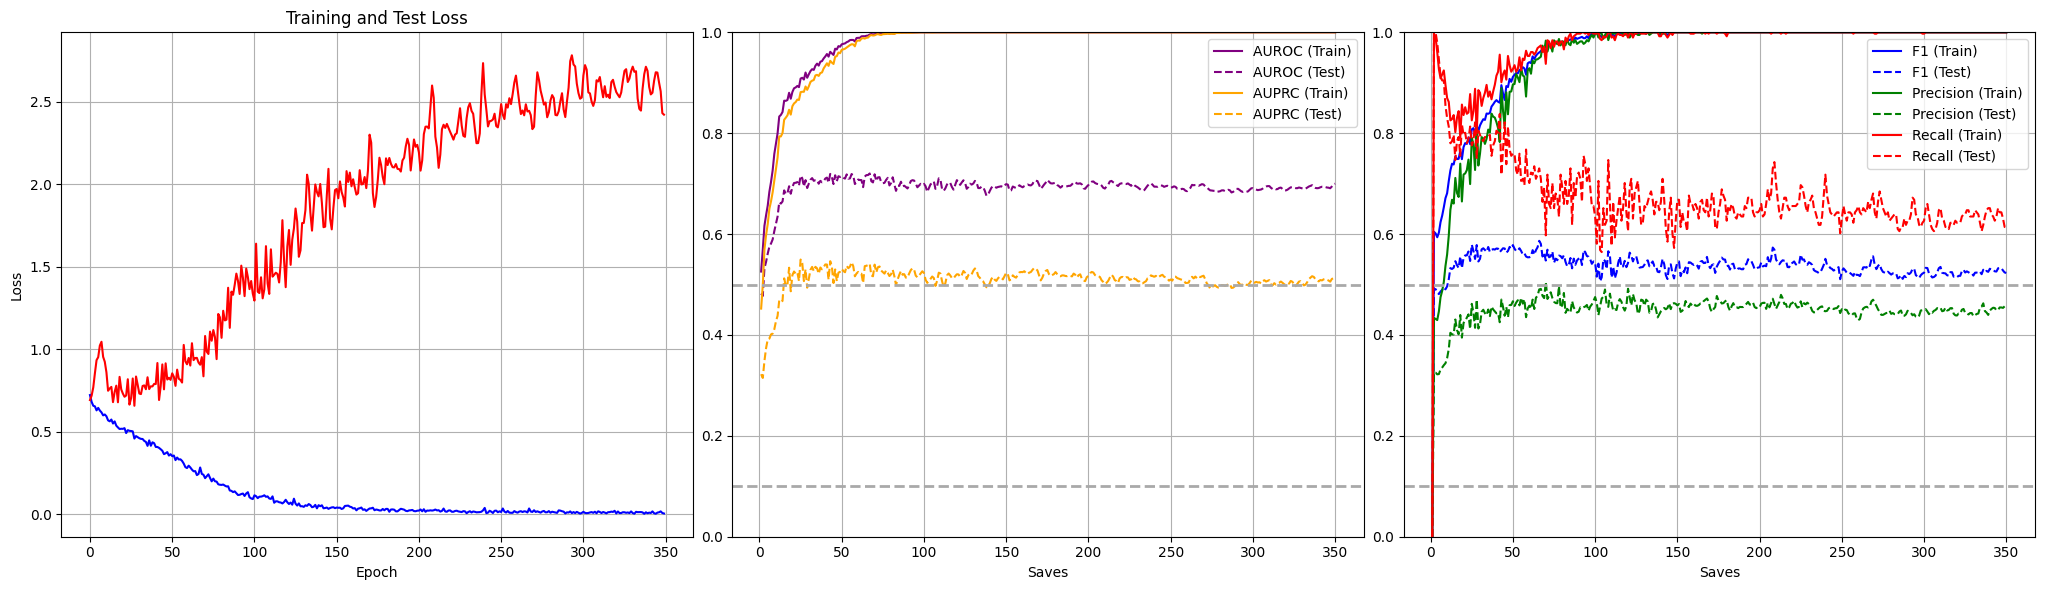

In [9]:
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)